In [13]:
import distutils.spawn
import os
from matplotlib import rc
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import torch

sns.set(font_scale=1.5)
if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

In [2]:
def sigma(x):
    """Activation function."""
    z = torch.zeros_like(x)
    return torch.minimum(torch.maximum((4*(x+0.5)**3), z), z+0.5) \
        + torch.minimum(torch.maximum((0.5 - 4*(0.5-x)**3), z), z+0.5)

In [3]:
class mynn(torch.nn.Module):
    def __init__(self, a, u, eta):
        super(mynn, self).__init__()
        self.a = torch.nn.Parameter(a)
        self.u = torch.nn.Parameter(u)
        self.eta = eta
        self.sigma = lambda x: sigma(x / self.eta)

    def forward(self, x):
        return torch.sum(self.a[..., None] * self.sigma(x - self.u[..., None]), dim = (0, 1))

In [4]:
def target(x):
    return torch.sum((x > 0.3).double(), axis = 0) + torch.sum((x > 0.5).double(), axis = 0) + torch.sum((x > 0.7).double(), axis = 0)

In [5]:
def is_good_solution(u):
    return torch.all(torch.any(torch.abs(model.u - 0.3) < 0.1, dim=0)) and torch.all(torch.any(torch.abs(model.u - 0.5) < 0.1, dim=0)) and torch.all(torch.any(torch.abs(model.u - 0.7) < 0.1, dim=0))

In [11]:
n_repeats = 20
n = 10**4
d = 10

metrics = {'loss': [], 'u': [], 'a': []}
for k in range(n_repeats):
    print(k)
    x = torch.rand(d, n)
    u = torch.rand(10, d)
    a = 3 * torch.rand(10, d)
    model = mynn(a, u, 0.01)
    optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
    
    n_epoch = 150
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        y_pred = model(x)
        y_target = target(x)
        criterion = torch.norm(y_pred - y_target) / n
        criterion.backward()
        optimizer.step()
    metrics['loss'].append(float(criterion))
    metrics['u'].append(model.u.detach().numpy())
    metrics['a'].append(model.a.detach().numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [14]:
filepath = 'rebuttal/10d-standard.pkl'
with open(filepath, 'wb') as file:
    pickle.dump(metrics, file)

In [15]:
metrics_fs = {'loss': [], 'u': [], 'a': []}
for k in range(n_repeats):
    print(k)
    x = torch.rand(d, n)
    u = torch.rand(10, d)
    a = 3 * torch.rand(10, d)
    model = mynn(a, u, 0.01)
    optimizer_a = torch.optim.SGD([model.a], lr=1.0)
    optimizer_u = torch.optim.SGD([model.u], lr=0.01)
    
    n_epoch = 5 * 10**3
    for epoch in range(n_epoch):
        optimizer_a.zero_grad()
        optimizer_u.zero_grad()
        y_pred = model(x)
        y_target = target(x)
        criterion = torch.norm(y_pred - y_target) / n
        if epoch % 1000 == 0:
            print(criterion)
        criterion.backward()
        optimizer_a.step()
        optimizer_u.step()
    metrics_fs['loss'].append(float(criterion))
    metrics_fs['u'].append(model.u.detach().numpy())
    metrics_fs['a'].append(model.a.detach().numpy())

0
tensor(0.5238, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0172, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0101, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0076, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0062, dtype=torch.float64, grad_fn=<DivBackward0>)
1
tensor(0.6245, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0184, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0111, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0083, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0061, dtype=torch.float64, grad_fn=<DivBackward0>)
2
tensor(0.6983, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0156, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0091, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0059, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0038, dtype=torch.float64, grad_fn=<DivBackward0>)
3
tensor(0.6001, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0179, dtype=torch.float

In [16]:
filepath = 'rebuttal/10d-fs.pkl'
with open(filepath, 'wb') as file:
    pickle.dump(metrics_fs, file)

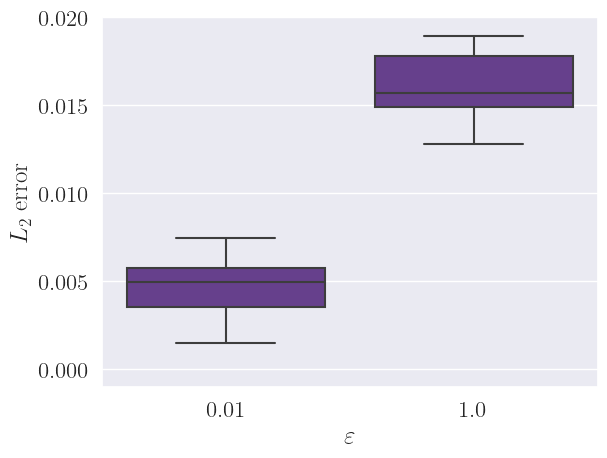

In [19]:
d = {r'$\varepsilon$': [1.0]*20 + [0.01]*20, r'$L_2$ error': metrics['loss'] + metrics_fs['loss']}
df = pd.DataFrame.from_dict(d)
sns.boxplot(data=df, x=r'$\varepsilon$', y=r'$L_2$ error', color='rebeccapurple')
#plt.yscale('log')
plt.ylim([-0.001, 0.02])
plt.savefig('rebuttal/plot_error_10d.png', dpi=150, bbox_inches='tight')
plt.show()